# Brain Tumor  Semantic Highlighting

---
## Imports

Imports all packages used in this project.

In [54]:
import torch
import os
from pathlib import Path
import torchvision.transforms as transforms 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
from torchvision.transforms import v2
import pandas as pd
from itertools import chain
from PIL import Image
from torch.utils.data import Dataset
import torch.nn.functional as F
import h5py
import numpy as np
from matplotlib.colors import ListedColormap
import re, random
from collections import defaultdict
from typing import Callable, Optional, Sequence, Dict, Any, List, Tuple
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader

---
## 1. Loading the data and preprocessing

Visually inspect images:

In [42]:
def _robust_norm(x, p_lo=0.5, p_hi=99.5):
    """Perform robust normalization using percentile clipping."""
    lo, hi = np.percentile(x, [p_lo, p_hi])
    x = np.clip(x, lo, hi)
    if hi > lo:
        x = (x - lo) / (hi - lo)
    else:
        x = np.zeros_like(x)
    return x

def _as_onehot3(mask):
    """
    Convert a (H, W) integer mask into a 3-channel one-hot mask (H, W, 3).
    Expected label values:
        1: Necrosis / Non-enhancing tumor
        2: Edema
        4: Enhancing tumor
    If none of these labels are present, returns all-zeros.
    """
    if mask.ndim == 3 and mask.shape[-1] == 3:
        return mask.astype(np.float32)
    oh = np.zeros(mask.shape + (3,), dtype=np.float32)
    oh[..., 0] = (mask == 1).astype(np.float32)
    oh[..., 1] = (mask == 2).astype(np.float32)
    oh[..., 2] = (mask == 4).astype(np.float32)
    return oh

def overlay_replace_on_flair(
    image,                       # (H,W,4) float
    mask,                        # (H,W,3) one-hot/prob OR (H,W) labels
    flair_idx=3,                 # index of FLAIR channel
    mask_colors=((1,0,0),(1,1,0),(0,1,0)),   # R/G/B for [Necrosis, Edema, Enhancing]
    thresh=0.5,                  # binarization threshold for prob masks
    conflict_mode="priority",    # "priority" or "argmax"
    alpha=None,                  # None to hard replace; float in (0,1) for alpha blend
    priority=(2,1,0),            # only used when conflict_mode="priority" (index in [0,1,2])
    show=True
):
    """
    Convert FLAIR to RGB and replace pixels under mask with class colors.
    If alpha is not None, do per-pixel blending instead of hard replacement.
    """
    H, W, C = image.shape
    assert C > flair_idx, "flair_idx out of range"
    base = _robust_norm(image[..., flair_idx])               # (H,W) in [0,1]
    base_rgb = np.repeat(base[..., None], 3, axis=2)        # (H,W,3)

    m = _as_onehot3(mask)                                    # (H,W,3)
    # binarize to avoid interpolation leakage
    m_bin = (m > thresh).astype(np.uint8)                   # (H,W,3)

    if conflict_mode == "argmax":
        # choose the channel with highest prob; mask out background
        cls_idx = np.argmax(m, axis=-1)                     # (H,W)
        fg = (m.max(axis=-1) > thresh)                      # (H,W) boolean
        # build a 3D boolean index per class
        for i, color in enumerate(mask_colors):
            sel = (cls_idx == i) & fg
            if np.any(sel):
                if alpha is None:
                    base_rgb[sel, :] = color
                else:
                    base_rgb[sel, :] = (1 - alpha) * base_rgb[sel, :] + alpha * np.array(color)
    elif conflict_mode == "priority":
        # apply in given order; later classes overwrite earlier ones
        for i in priority:
            sel = m_bin[..., i].astype(bool)
            if np.any(sel):
                if alpha is None:
                    base_rgb[sel, :] = mask_colors[i]
                else:
                    base_rgb[sel, :] = (1 - alpha) * base_rgb[sel, :] + alpha * np.array(mask_colors[i])
    else:
        raise ValueError("conflict_mode must be 'priority' or 'argmax'")

    if show:
        plt.figure(figsize=(6,6))
        plt.imshow(base_rgb, interpolation="nearest")
        plt.title("Mask replaced on FLAIR (RGB)")
        plt.axis("off")
        plt.show()

    return base_rgb

def display_image(
    file_path: str,
    modality_names=("T1","T1Gd","T2","FLAIR"),
    mask_names=("Necrosis","Edema","Enhancing"),
    overlay_modality: str | None = "FLAIR",
    overlay_alpha: float = 0.35,
    show_contour: bool = True,
    # per-channel colors (RGB tuples or hex). Order must match mask_names / channels
    mask_colors=((0.0, 1.0, 0.0),  # Necrosis -> green
                 (1.0, 0.0, 1.0),  # Edema    -> magenta
                 (1.0, 0.0, 0.0)), # Enhancing-> red
):
    """
    Visualize a single .h5 BraTS slice file containing:
        - image: (H, W, 4) multimodal MRI data
        - mask : (H, W, 3) or (H, W) segmentation mask

    Parameters
    ----------
    file_path : str
        Path to the .h5 file.
    modality_names : tuple of str
        Names of the 4 MRI modalities, in order.
    mask_names : tuple of str
        Names of the 3 segmentation channels.
    overlay_modality : str | None
        Which modality to overlay the mask on (default: "FLAIR").
        Set to None to disable overlay.
    overlay_alpha : float
        Transparency for mask overlay (0–1).
    show_contour : bool
        If True, draw contour lines around mask regions.
    """
    # --- Load data ---
    with h5py.File(file_path, "r") as f:
        image = f["image"][:]  # (H, W, 4)
        mask  = f["mask"][:]   # (H, W, 3) or (H, W)
        # print the shape
        print(f"Image shape: {image.shape}, Mask shape: {mask.shape}")

    # --- Convert mask safely to one-hot format ---
    if mask.ndim == 2 or (mask.ndim == 3 and mask.shape[-1] == 1):
        mask = _as_onehot3(mask.squeeze())
    elif mask.ndim == 3 and mask.shape[-1] == 3:
        mask = mask.astype(np.float32)
    else:
        raise ValueError(f"Unexpected mask shape: {mask.shape}, expected (H,W,3) or (H,W).")

    # --- Display each modality ---
    H, W, C = image.shape
    if C != 4:
        raise ValueError(f"Expected 4 channels, got {image.shape}")

    for i in range(4):
        plt.figure(figsize=(4.5, 4.5))
        plt.imshow(_robust_norm(image[..., i]), cmap="gray")
        plt.title(modality_names[i] if i < len(modality_names) else f"Modality {i}")
        plt.axis("off")
        plt.show()
    
    '''
    # --- Display each mask channel with its own color ---
    for i in range(3):
        m = mask[..., i]
        plt.figure(figsize=(4.5, 4.5))
        # build a 2-color discrete cmap: background transparent-ish, foreground = mask_colors[i]
        fg = mask_colors[i]
        cmap = ListedColormap([(0,0,0,0), (*fg, 1.0)])  # RGBA
        plt.imshow(m, cmap=cmap, interpolation="nearest")
        plt.title(mask_names[i] if i < len(mask_names) else f"Mask {i}")
        plt.axis("off")
        plt.show()
    '''

    # --- Overlay each mask channel using its dedicated color ---
    rgb = overlay_replace_on_flair(
        image, mask,
        flair_idx=3,
        mask_colors=mask_colors,
        thresh=0.5,
        conflict_mode="priority",               # or "argmax"
        alpha=None,                             # None=hard replace；0.35=blend
        priority=(2,1,0)                        # Enhancing > Edema > Necrosis
    )
        
    '''
    # Optional: combined label map (0=bg, 1/2/3 = channels)
    combined = np.zeros(mask.shape[:2], dtype=int)
    for i in range(3):
        combined[mask[..., i] > 0.5] = i + 1

    combo_cmap = ListedColormap([
        (0,0,0,0),                    # 0 background transparent
        (*mask_colors[0], 1.0),       # 1
        (*mask_colors[1], 1.0),       # 2
        (*mask_colors[2], 1.0),       # 3
    ])
    plt.figure(figsize=(5,5))
    plt.imshow(combined, cmap=combo_cmap, interpolation="nearest")
    plt.title("Combined Mask")
    plt.axis("off")
    plt.show()
    '''

Image shape: (240, 240, 4), Mask shape: (240, 240, 3)


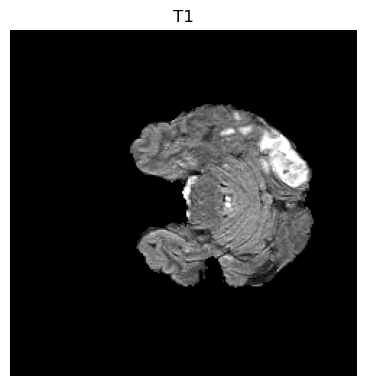

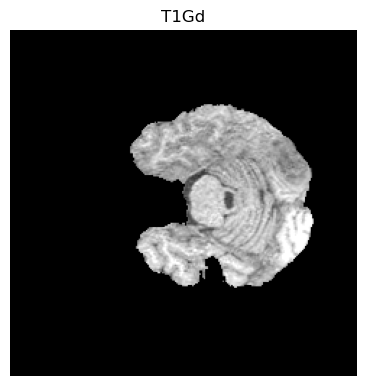

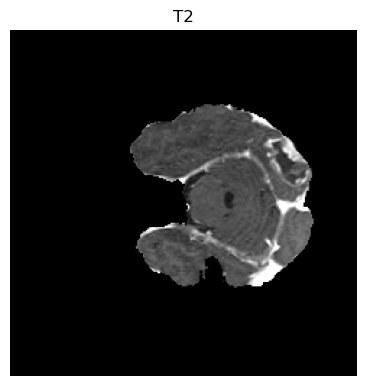

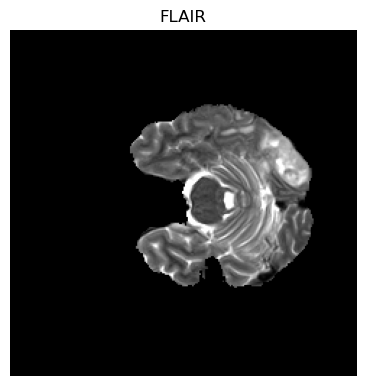

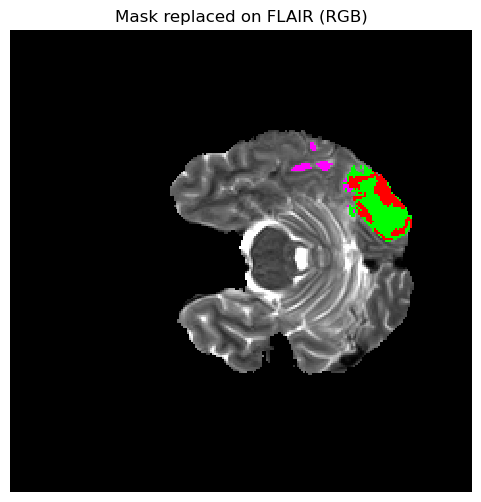

In [43]:
image_path = "./brats2020-training-data/BraTS2020_training_data/content/data/volume_41_slice_35.h5"
display_image(
    image_path,
    modality_names=("T1", "T1Gd", "T2", "FLAIR"),
    mask_names=("Necrosis-1", "Edema-2", "Enhancing-4"),
    overlay_modality="FLAIR",
    overlay_alpha=0.35,
    show_contour=True
)


In [ ]:

import random
from typing import List, Tuple, Optional, Sequence

def group_by_volume(root: Path) -> Dict[int, List[Path]]:
    groups = defaultdict(list)
    for p in root.glob("*.h5"):
        # m = H5_RE.match(p.name)
        m = H5_RE.fullmatch(p.name)
        if m:
            vid = int(m.group(1))
            groups[vid].append(p)
    return {k: sorted(v) for k, v in sorted(groups.items())}


def _largest_remainder_counts(n: int, shares: Sequence[float]) -> List[int]:
    """
    Convert fractional shares to integer counts that sum to n (Largest Remainder Method).
    """
    raw = [n * s for s in shares]
    base = [int(x) for x in raw]
    rem = n - sum(base)
    order = sorted(range(len(shares)), key=lambda i: raw[i] - base[i], reverse=True)
    for k in range(rem):
        base[order[k]] += 1
    return base

def split_volumes_flexible(
    volume_ids: List[int],
    *,
    seed: int = 45,
    ratios: Tuple[float, float, float] = (0.70, 0.15, 0.15),
    n_select: Optional[int] = None,
    sample_frac: Optional[float] = None,
    shuffle_before_split: bool = True,
) -> Tuple[List[int], List[int], List[int], List[int]]:
    """
    Split volume IDs into train/val/test with flexible sampling.

    Parameters
    ----------
    volume_ids : list of int
        All available volume IDs (e.g., patient IDs).
    seed : int
        Random seed for deterministic sampling/shuffling.
    ratios : (float, float, float)
        Train/val/test proportions. They will be normalized to sum to 1.0.
    n_select : int or None
        If provided, sample exactly this many volumes from `volume_ids` (without replacement)
        before splitting. If None, use `sample_frac` or all volumes.
    sample_frac : float or None
        If provided (0 < frac <= 1), sample a fraction of `volume_ids` (rounded via largest
        remainder) before splitting. Ignored if `n_select` is given. If None, use all volumes.
    shuffle_before_split : bool
        If True, shuffle the selected IDs before allocating to each split.

    Returns
    -------
    train_ids, val_ids, test_ids, selected_ids : lists of int
        Sorted IDs for each split, and the full list of selected IDs used for splitting.

    Notes
    -----
    - Selection happens at the *volume level* (no leakage across splits).
    - If both `n_select` and `sample_frac` are None, all volumes are used.
    - If the dataset is small, some splits may be empty (counts can be 0).
    """
    ids = list(volume_ids)
    rng = random.Random(seed)

    # ---- normalize ratios ----
    r_tr, r_val, r_te = ratios
    s = r_tr + r_val + r_te
    r_tr, r_val, r_te = r_tr / s, r_val / s, r_te / s

    # ---- choose how many to use ----
    N = len(ids)
    if n_select is not None:
        if not (1 <= n_select <= N):
            raise ValueError(f"n_select must be in [1, {N}], got {n_select}")
        selected_ids = sorted(rng.sample(ids, n_select))
    elif sample_frac is not None:
        if not (0 < sample_frac <= 1.0):
            raise ValueError("sample_frac must be in (0, 1].")
        k = max(1, int(round(N * sample_frac)))
        selected_ids = sorted(rng.sample(ids, k))
    else:
        # use all volumes
        selected_ids = sorted(ids)

    # ---- optional shuffle before split ----
    alloc = selected_ids[:]
    if shuffle_before_split:
        rng.shuffle(alloc)

    # ---- compute split counts (largest remainder to avoid drift) ----
    n_tr, n_val, n_te = _largest_remainder_counts(len(alloc), [r_tr, r_val, r_te])

    train_ids = sorted(alloc[:n_tr])
    val_ids   = sorted(alloc[n_tr:n_tr + n_val])
    test_ids  = sorted(alloc[n_tr + n_val:])

    assert len(train_ids) + len(val_ids) + len(test_ids) == len(selected_ids)
    return train_ids, val_ids, test_ids, selected_ids


In [53]:
# # DATA_DIR = "./brats2020-training-data/BraTS2020_training_data/content/data"
# DATA_DIR = Path("./brats2020-training-data/BraTS2020_training_data/content/data/").resolve()
# H5_RE = re.compile(r"^volume_(\d+)_slice_(\d+)\.h5$")

# groups = group_by_volume(DATA_DIR)   # your existing function
# all_vol_ids = list(groups.keys())

# # A) Use exactly 50 patients (seed=45), ratios 70/15/15
# train_ids, val_ids, test_ids, used_ids = split_volumes_flexible(
#     all_vol_ids, seed=45, ratios=(0.70, 0.15, 0.15), n_select=25
# )


'''
# B) Use the entire dataset with custom ratios (e.g., 80/10/10)
train_ids, val_ids, test_ids, used_ids = split_volumes_flexible(
    all_vol_ids, seed=45, ratios=(0.80, 0.10, 0.10)
)

# C) Use 60% of all volumes, then split 7:2:1
train_ids, val_ids, test_ids, used_ids = split_volumes_flexible(
    all_vol_ids, seed=45, ratios=(0.7, 0.2, 0.1), sample_frac=0.60
)
'''

'\n# B) Use the entire dataset with custom ratios (e.g., 80/10/10)\ntrain_ids, val_ids, test_ids, used_ids = split_volumes_flexible(\n    all_vol_ids, seed=45, ratios=(0.80, 0.10, 0.10)\n)\n\n# C) Use 60% of all volumes, then split 7:2:1\ntrain_ids, val_ids, test_ids, used_ids = split_volumes_flexible(\n    all_vol_ids, seed=45, ratios=(0.7, 0.2, 0.1), sample_frac=0.60\n)\n'

### 1.1 Dataset

In [56]:
def robust_norm(x: np.ndarray, lo_p=0.5, hi_p=99.5) -> np.ndarray:
    lo, hi = np.percentile(x, [lo_p, hi_p])
    x = np.clip(x, lo, hi)
    denom = (hi - lo) if hi > lo else 1.0
    return (x - lo) / denom

def flatten_files(groups: Dict[int, List[Path]], ids: List[int]) -> List[Path]:
    out = []
    for vid in ids:
        out.extend(groups[vid])
    return sorted(out)

def to_onehot3_from_labels(lbl: np.ndarray) -> np.ndarray:
    """labels in {0,1,2,4} or {0,1,2,3} -> one-hot (H,W,3)."""
    # allow 0/1/2/3 or 0/1/2/4
    oh = np.zeros(lbl.shape + (3,), dtype=np.float32)
    oh[..., 0] = (lbl == 1)        # Necrosis / Non-enhancing
    oh[..., 1] = (lbl == 2)        # Edema
    oh[..., 2] = (lbl == 3) | (lbl == 4)  # Enhancing (merge 4->3)
    return oh

def to_label_from_onehot3(oh: np.ndarray, thr: float = 0.5) -> np.ndarray:
    """one-hot/prob (H,W,3) -> labels (H,W) in {0,1,2,3}."""
    fg = (oh.max(axis=-1) > thr)
    cls = np.argmax(oh, axis=-1) + 1  # 1/2/3
    cls[~fg] = 0
    return cls.astype(np.int64)

class BrainTumorMRIData(Dataset):
    """
    H5 file schema:
      - 'image': (H, W, 4) -> [T1, T1ce, T2, FLAIR] (assumed order; set t1ce_idx accordingly)
      - 'mask' : (H, W, 3) one-hot/prob   OR   (H, W) labels in {0,1,2,4}

    Returns
    -------
    dict with:
      image: FloatTensor (1, H, W)  # T1ce only
      mask : LongTensor  (H, W)     # 0/1/2/3  (or FloatTensor (3,H,W) if return_onehot=True)
      path : str
    """
    def __init__(
        self,
        files: Sequence[Path | str],
        t1ce_idx: int = 1,
        return_onehot: bool = False,
        intensity_norm: bool = True,
        joint_transform: Optional[Callable[[Dict[str, Any]], Dict[str, Any]]] = None,
        img_transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
        mask_transform: Optional[Callable[[torch.Tensor], torch.Tensor]] = None,
        image_dtype: torch.dtype = torch.float32,
        mask_dtype_onehot: torch.dtype = torch.float32,
    ):
        self.files = [Path(f) for f in files]
        self.t1ce_idx = t1ce_idx
        self.return_onehot = return_onehot
        self.intensity_norm = intensity_norm
        self.joint_transform = joint_transform
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.image_dtype = image_dtype
        self.mask_dtype_onehot = mask_dtype_onehot

    def __len__(self) -> int:
        return len(self.files)

    def _load_h5(self, p: Path) -> tuple[np.ndarray, np.ndarray]:
        with h5py.File(p, "r") as f:
            image = f["image"][:]   # (H,W,4)
            mask  = f["mask"][:]    # (H,W,3) or (H,W)
        return image, mask

    def _prepare_xy(self, image: np.ndarray, mask: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        x = image[..., self.t1ce_idx]               # (H,W)
        if self.intensity_norm:
            x = robust_norm(x)

        # mask -> onehot (H,W,3)
        if mask.ndim == 2:
            # labels could be 0/1/2/4; convert
            mask_oh = to_onehot3_from_labels(mask)
        else:
            mask_oh = mask.astype(np.float32)

        if self.return_onehot:
            y = mask_oh.transpose(2, 0, 1)         # (3,H,W)
        else:
            y_lbl = to_label_from_onehot3(mask_oh) # (H,W)
            y = y_lbl
        return x, y

    def __getitem__(self, index: int) -> Dict[str, Any]:
        path = self.files[index]
        image, mask = self._load_h5(path)
        x, y = self._prepare_xy(image, mask)        # x: (H,W), y: (H,W) or (3,H,W)

        # ---- convert to tensor before/after transforms depending on your pipeline ----
        # For Albumentations joint_transform, keep numpy -> pass {"image": x, "mask": y}
        if self.joint_transform is not None:
            # Albumentations expects (H,W) for single channel & (H,W) or (H,W,C) for mask
            sample = {"image": x, "mask": y}
            out = self.joint_transform(**sample) if hasattr(self.joint_transform, "__call__") else self.joint_transform(sample)
            x, y = out["image"], out["mask"]

        # to tensors
        x_t = torch.from_numpy(x).unsqueeze(0).to(self.image_dtype)  # (1,H,W)
        if self.return_onehot:
            y_t = torch.from_numpy(y).to(self.mask_dtype_onehot)     # (3,H,W)
        else:
            y_t = torch.from_numpy(y).long()                          # (H,W)

        # per-modality transforms (torchvision, etc.)
        if self.img_transform is not None:
            x_t = self.img_transform(x_t)
        if self.mask_transform is not None:
            y_t = self.mask_transform(y_t)

        return {"image": x_t, "mask": y_t, "path": str(path)}

    def __repr__(self) -> str:
        return (f"{self.__class__.__name__}(n={len(self)}, t1ce_idx={self.t1ce_idx}, "
                f"return_onehot={self.return_onehot}, intensity_norm={self.intensity_norm})")


In [ ]:
# 同步空间增强（对 image/mask 同时作用）
joint_tf = A.Compose([
    A.PadIfNeeded(args.crop, args.crop, border_mode=0, pad_val=0, pad_val_mask=0),
    A.RandomCrop(240, 240),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.2),
    A.RandomRotate90(p=0.5),
], additional_targets={})  # mask 自动处理

# 图像独立变换（若 joint_tf 已输出 numpy，可省略或加噪声等）
img_tf = None
mask_tf = None

# 构建分割数据集
# DATA_DIR = "./brats2020-training-data/BraTS2020_training_data/content/data"
DATA_DIR = Path("./brats2020-training-data/BraTS2020_training_data/content/data/").resolve()
H5_RE = re.compile(r"^volume_(\d+)_slice_(\d+)\.h5$")


groups = group_by_volume(DATA_DIR)   # your existing function
all_vol_ids = list(groups.keys())

# A) Use exactly 50 patients (seed=45), ratios 70/15/15
train_ids, val_ids, test_ids, used_ids = split_volumes_flexible(
    all_vol_ids, seed=45, ratios=(0.70, 0.15, 0.15), n_select=25
)

train_files = flatten_files(groups, train_ids)
val_files   = flatten_files(groups, val_ids)

train_ds = BrainTumorMRIData(
    train_files, t1ce_idx=1, return_onehot=False,
    joint_transform=joint_tf, img_transform=img_tf, mask_transform=mask_tf
)
val_ds = BrainTumorMRIData(
    val_files, t1ce_idx=1, return_onehot=False,
    joint_transform=None
)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=8, shuffle=False, num_workers=4, pin_memory=True)


### 1.2 Preprocessing 
The `DogsCatsData` class constructor has an argument called `transform`. It allows us to transform or preprocess all the images in a batch, from the raw image data to a more suitable format. There are multiple motivations for preprocessing:

- Some transformations might be needed to actually make the data work with our network (reshaping, permuting dimensions et c.).
- Make the training more efficient by making the input dimensions smaller, e.g. resizing, cropping.
- Artificially expanding the training data through [data augmentation](https://cartesianfaith.com/2016/10/06/what-you-need-to-know-about-data-augmentation-for-machine-learning/)
- We have some clever idea of how to change the data to create a simpler optimisation problem.

We do not expect you to do data augmentation, but feel free to preprocess the data as you see fit. Use the [documentation](https://pytorch.org/vision/stable/transforms.html#torchvision-transforms) to view available transforms. Extra important is the `Compose` transformation, which is a meta-transformation which composes actual ones, and the `ToTensor` transformation which is the simplest way to go from image to tensor format.


Hints:
- Revisit the `DogsCatsData` example usage to see how to use the `Compose` and `ToTensor` transformations.
- When feeding the images to your CNN, you'll probably want all of them to have the same spatial size, even though the .jpeg files differ in this. Resizing the images can be done using the previously mentioned Pytorch Transforms.
- Resizing the images to a smaller size while loading them can be beneficial as it speeds up training. The CNN's do surprisingly well on 64x64 images. Shorter training cycles give you more time to experiment! **Note**: The MobileNetV2 network used later in this assignment is specialised for images that are 224x224.

We encourage you to explore the data and choose transformations that you believe to be useful. For exploration we provide you with a helper function to visually compare transformations side by side:

In [ ]:
def compare_transforms(transformations, index):
    """Visually compare transformations side by side.
    Takes a list of DogsCatsData datasets with different compositions of transformations.
    It then display the `index`th image of the dataset for each transformed dataset in the list.

    Example usage:
        compare_transforms([dataset_with_transform_1, dataset_with_transform_2], 0)

    Args:
        transformations (list(DogsCatsData)): list of dataset instances with different transformations
        index (int): Index of the sample in the dataset you wish to compare.
    """

    # Here we combine two functions from basic python to validate the input to the function:
    # - `all` takes an iterable (something we can loop over, e.g. a list) of booleans
    #    and returns True if every element is True, otherwise it returns False.
    # - `isinstance` checks whether a variable is an instance of a particular type (class)
    if not all(isinstance(transf, Dataset) for transf in transformations):
        raise TypeError(
            "All elements in the `transformations` list need to be of type Dataset"
        )

    num_transformations = len(transformations)
    fig, axes = plt.subplots(1, num_transformations)

    # This is just a hack to make sure that `axes` is a list of the same length as `transformations`.
    # If we only have one element in the list, `plt.subplots` will not create a list of a single axis
    # but rather just an axis without a list.
    if num_transformations == 1:
        axes = [axes]

    for counter, (axis, transf) in enumerate(zip(axes, transformations)):
        axis.set_title(f"transf: {counter}")
        image_tensor = transf[index][0]
        display_image(axis, image_tensor)

    plt.show()

In [ ]:
# Explore your dataset in this cell, you do not need to produce any results.
img_size = None
train_dataset = None

# YOUR CODE HERE
from torchvision.transforms import v2

test_index = 10
# 64*64 224*224
resize_size = 64 # 224 
img_size = resize_size

# 1
# transform_1 = v2.Compose([v2.Resize(resize_size,resize_size),
#                           v2.ToTensor()]) # v2.ToTensor() = ToImage() + ToDtype(torch.float32, scale=True)
transform_1 = v2.Compose([
    v2.Resize(resize_size, antialias=True), 
    v2.CenterCrop((resize_size, resize_size)),# RandomCrop/PadToSquare
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])
dataset_with_transform_1 = DogsCatsData(small_train_path, transform_1)

# 2 
# calculate the mean and std in train_dataset
small_train_loader = torch.utils.data.DataLoader(dataset_with_transform_1, batch_size=32, shuffle=False)
mean = 0.
std = 0.
nb_samples = 0.
for data, _ in small_train_loader:
    batch_samples = data.size(0) # data: [B, C, H, W]
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples
mean /= nb_samples
std /= nb_samples
print("mean:", mean)
print("std:", std)
transform_2 = v2.Compose([
    v2.Resize(resize_size, antialias=True),
    v2.RandomCrop((resize_size, resize_size)),# CenterCrop/RandomCrop/PadToSquare
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

dataset_with_transform_2 = DogsCatsData(small_train_path, transform_2)


# 3
transform_3 = v2.Compose([
    v2.Resize(resize_size, antialias=True),
    v2.RandomCrop((resize_size, resize_size)),# CenterCrop/RandomCrop/PadToSquare
    v2.RandomHorizontalFlip(p=0.5),
    v2.AutoAugment(
    policy=v2.AutoAugmentPolicy.IMAGENET,                    # or CIFAR10 / SVHN
    interpolation=v2.InterpolationMode.BILINEAR,
    fill=0),                                                  # fill value for the area outside the transform in the input image
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std)
])

dataset_with_transform_3 = DogsCatsData(small_train_path, transform_3)
 
compare_transforms([dataset_with_transform_1, dataset_with_transform_2, dataset_with_transform_3], test_index)

### 1.3 Data loaders
Creating a `DataLoader` instance:

---
## 2. Training

### 2.1 Baseline: Encoder–Decoder GAN

In [ ]:

class EncoderDecoderGAN(nn.Module):
    def __init__(self, img_size: int):
        super().__init__()
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        pass

### 2.2 The training loop

In [ ]:
def output_to_label(z):
    pass

In [108]:
def training_loop(
    model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every
):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs + 1):
        model, train_loss, train_acc = train_epoch(
            model, optimizer, loss_fn, train_loader, val_loader, device, print_every
        )
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(
            f"Epoch {epoch}/{num_epochs}: "
            f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
            f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
            f"Val. loss: {val_loss:.3f}, "
            f"Val. acc.: {val_acc:.3f}"
        )
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    return model, train_losses, train_accs, val_losses, val_accs


def train_epoch(
    model, optimizer, loss_fn, train_loader, val_loader, device, print_every
):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):
        inputs, labels = x.to(device), y.to(device)
        optimizer.zero_grad()
        z = model.forward(inputs)
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        hard_preds = output_to_label(z)
        acc_batch_avg = (hard_preds == labels).float().mean().item()
        train_acc_batches.append(acc_batch_avg)

        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(
                f"\tBatch {batch_index}/{num_batches}: "
                f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                f"\tVal. loss: {val_loss:.3f}, "
                f"\tVal. acc.: {val_acc:.3f}"
            )

    return model, train_loss_batches, train_acc_batches


def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            z = model.forward(inputs)

            batch_loss = loss_fn(z, labels.float())
            val_loss_cum += batch_loss.item()
            hard_preds = output_to_label(z)
            acc_batch_avg = (hard_preds == labels).float().mean().item()
            val_acc_cum += acc_batch_avg
    return val_loss_cum / len(val_loader), val_acc_cum / len(val_loader)

In [ ]:
# Train your model in this cell, you do not need to produce any results.





# Save model
torch.save(
    {
        "model_state_dict": first_model.state_dict(),
        "train_losses": first_train_losses,
        "train_accs": first_train_accs,
        "val_losses": first_val_losses,
        "val_accs": first_val_accs,
    },
    "./first_model.ckpt",
)


### 2.3 Visualisation

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.
Note that the given training loop produces metrics at different intervals for training and validation, make sure that you align your metrics in a way that makes sense.

**Note also:** this kind of visualization will have to be done more times in this notebook. We advise you to write a function that does the plotting and re-use it later.

---
## 3. Target: U-Net

In [ ]:

class UNetBase(nn.Module):
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()
        pass

    def forward(self, x):
        pass

In [ ]:
# Train the model

# Save the model
torch.save(
    {
        "model_state_dict": impr_model.state_dict(),
        "train_losses": impr_train_losses,
        "train_accs": impr_train_accs,
        "val_losses": impr_val_losses,
        "val_accs": impr_val_accs,
    },
    "./improved_model.ckpt",
)

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

Save your model to disk.

---
## 4. Transfer Learning

In [ ]:
from torchvision import models

base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)

print(base_model.classifier)

Create a new model named `head` as a so-called head network to the base model.
MobileNetV2 is quite a deep network so think about what would be a reasonable model head for transfer learning.

*Hint:*
- You can access and modify the top layers of the MobileNetV2 model with `base_model.classifier`, and the remaining layers with `base_model.features`.
- You can get the number of output features of `base_model.features` with `base_model.classifier[1].in_features`

In [125]:
head = None

# YOUR CODE HERE
import torch
import torch.nn as nn
from torchvision import transforms

in_features = base_model.classifier[1].in_features  # 1280

head = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(in_features, 1),
    nn.Sigmoid()
)

Now add the new model on top of the base model. Your full model should be stored in the `TL_model` variable.

In [ ]:
# YOUR CODE HERE
class TLWrapper(nn.Module):
    def __init__(self, backbone: models.MobileNetV2, head: nn.Module):
        super().__init__()
        pass
    def forward(self, x):
        pass

    def freeze_backbone(self):
        for p in self.features.parameters():
            p.requires_grad = False

    def unfreeze_backbone(self):
        for p in self.features.parameters():
            p.requires_grad = True

### Update:
# 直接使用 base_model.classifier = head 更新

### 4.1 Using backbone features

Now we're almost ready to train the new model. For transfer learning we want to freeze all but the top layers in your architecture (i.e. signal to the optimizer that the bottom layers should not be changed during optimization). We do that by setting the attribute `requires_grad` of every parameter in the feature sub-network of `TL_model` to `False`.

In [131]:
# YOUR CODE HERE
for p in TL_model.features.parameters():
    p.requires_grad = False

Prepare dataloaders for transfer learning. Don't forget that MobileNetV2 is specialised for images of a **certain size**.

Perform the transfer learning by training the top layers of your model.

In [ ]:
# Train the model


# Save the model
torch.save(
    {
        "model_state_dict": TL_model.state_dict(),
        "train_losses": tl_train_losses,
        "train_accs": tl_train_accs,
        "val_losses": tl_val_losses,
        "val_accs": tl_val_accs,
    },
    "./TL_model.ckpt",
)

Create two plots. In one of them, plot the loss in the training and the validation datasets. In the other one, plot the accuracy in the training and validation datasets.

How does the model perform, compared to the model obtained in step 3? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

In [ ]:
# YOUR CODE HERE
model1 = ("impr_model", impr_train_accs,  impr_val_accs)
model2 = ("TL_model", tl_train_accs, tl_val_accs)
model_compare(
    models=[model1, model2],
    steps_per_epoch=None,
    smooth_k=2,            
    title="Accuracy comparison"
)

### 4.2 Fine-tuning

Now that we have a better starting point for the top layers, we can train the entire network. Unfreeze the bottom (backbone) layers of `TL_model` by resetting the `requires_grad` attribute to `True`.

In [140]:
# YOUR CODE HERE
# Unfreeze the whole backbone
for p in TL_model.features.parameters():
    p.requires_grad = True


Fine tune the model by training all the layers.

In [ ]:
# Train model

# Save model
torch.save(
    {
        "model_state_dict": ft_model.state_dict(),
        "train_losses": ft_train_losses,
        "train_accs": ft_train_accs,
        "val_losses": ft_val_losses,
        "val_accs": ft_val_accs,
    },
    "./ft_model.ckpt",
)

How does the model perform, compared to the model trained with frozen layers? Create one plot with the training accuracy and another with the validation accuracy of the two scenarios.

## 5. Evaluation on test set